# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import re

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [ ]:
train.isnull().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [ ]:
train = train.fillna('')
train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [ ]:
test.isnull().sum().sum()

790

In [ ]:
test = test.fillna('')
test.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [ ]:
train.groupby('target').count()['id']

target
0    3024
1    2305
Name: id, dtype: int64

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [ ]:
popular_keywords = train['keyword'].value_counts()[0:10].index

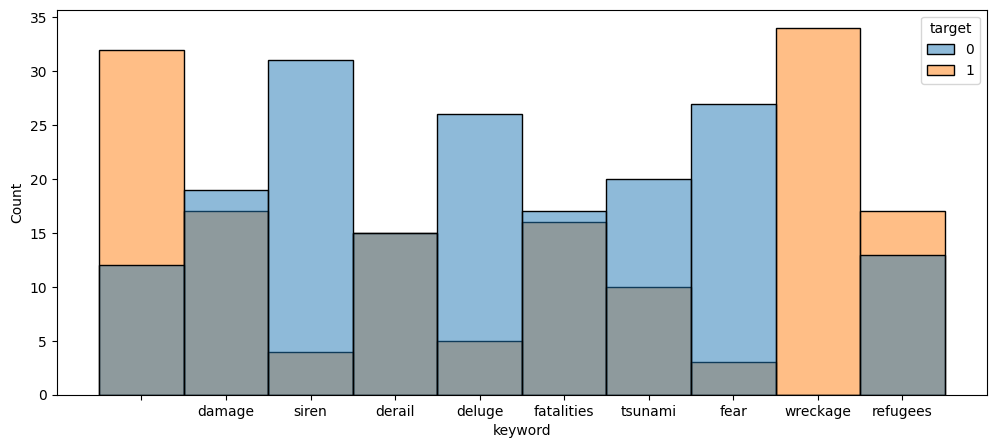

In [ ]:
data = train[train['keyword'].isin(popular_keywords)]
plt.figure(figsize = (12, 5))
sns.histplot(data=data, x="keyword", hue="target")
plt.show()

**Выводы**: В количественном объеме больше всего ключевых слов - пустая строка, что неудивительно, скорее всего пустая строка несет в себе множество различных слов, которые просто не дошли до нас в своем уникальном обличии, поэтому сильно полезной информации из пустой строки не извлечешь.

Слова с хорошим сигналом - это wreckage, siren и fear. Так как они имеют классовое преимущество (то есть популярность в классе 1 гораздо выше популярности в классе 0 или наоборот)

Слова с достаточно плохим сигналом - это damage, derail, fatalities, и refugees. По ним очень сложно будет определять принадлежность к классу, так как встречаются они в обоих классах одинаково.

## Задание 3 (0.5 балла)

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [ ]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [ ]:
train_new = train.drop('id', axis=1)
train_new['text'] = train_new['keyword'] + train_new['location'] + train_new['text']

train_new = train_new.drop('keyword', axis=1)
train_new = train_new.drop('location', axis=1)

#пригодится в дальнейшем:
test_new = test.drop('id', axis=1)
test_new['text'] = test_new['keyword'] + test_new['location'] + test_new['text']

test_new = test_new.drop('keyword', axis=1)
test_new = test_new.drop('location', axis=1)

In [ ]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivorsMarietta, GAStemming from my #Cubs ta...",1
7122,violent%20stormIf you were the NWS wth a rotat...,1
2769,devastationAtlanta g.a.http://t.co/Gxgm1T3W0J ...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_new['text'])


In [ ]:
X.shape

(5329, 22738)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось?

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [ ]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    digits = '0123456789'

    for x in s:
      if x in digits:
        return True
        break

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию

    for x in s:
      if x in punctuation:
        return True
        break

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s[0] == '#'

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s[0] == '@'

def investigate_vocabulary(vocabulary):
    digits = 0
    punc = 0
    hash = 0
    ment = 0
    for key in vocabulary.keys():
      if contains_digit(key):
        digits += 1
      if contains_punctuation(key):
        punc += 1
      if is_hashtag(key):
        hash += 1
      if is_mention(key):
        ment += 1
    print('With digit:      ', digits
          )
    print('With punctuation:', punc
          )
    print('Hashtags:        ', hash
          )
    print('Mentions:        ', ment
          )




In [ ]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [ ]:
investigate_vocabulary(vectorizer.vocabulary_
                       )

With digit:       4590
With punctuation: 317
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [ ]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [ ]:
tweet = CountVectorizer(tokenizer= lambda text: TweetTokenizer().tokenize(text))
tw = tweet.fit_transform(train_new['text'])

In [ ]:
tw.shape

(5329, 23874)

In [ ]:
investigate_vocabulary(tweet.vocabulary_
                       )

With digit:       4609
With punctuation: 7573
Hashtags:         1474
Mentions:         1678


**Сравнение:** Здесь уже работает другой токенизатор, разработанный специально для твитов. Он распознал гораздо большее и разнообразное количество слов, чем предыдущий.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно:

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [ ]:
nltk.download("stopwords", quiet = True)
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

In [ ]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return s.isalpha()

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    flag_1 = False
    flag_2 = False
    for x in s:
      if x not in punctuation:
        return False
        break
      if x == ')' or x == '(':
        flag_2 = True
    flag_1 = True

    return flag_1 and flag_2

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s[0] == '#' and s[1:].isalpha()

def custom_tokenizer(s: str) -> List[str]:
    s = s.lower()
    List = TweetTokenizer().tokenize(s)

    List = [i for i in List if i not in stopwords.words('english')]

    List = [i for i in List if (contains_only_latin_letters(i) == False and is_emoji(i) == False and is_hashtag(i) == False) == False]

    stemmer = SnowballStemmer('english')
    List = [stemmer.stem(w) for w in List]

    return List








In [ ]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [ ]:
[custom_tokenizer(i) for i in train_new['text'][:10]]

[['bridg',
  'australia',
  'ûªs',
  'collaps',
  'trent',
  'bridg',
  'among',
  'worst',
  'histori',
  'england',
  'bundl',
  'australia'],
 ['hailcarol',
  'stream',
  'illinoisgreat',
  'michigan',
  'techniqu',
  'camp',
  'thank',
  '#goblu',
  '#wrestleon'],
 ['policehouston',
  'cnn',
  'tennesse',
  'movi',
  'theater',
  'shoot',
  'suspect',
  'kill',
  'polic'],
 ['riotingstil', 'riot', 'coupl', 'hour', 'left', 'class'],
 ['woundslak',
  'highlandscrack',
  'path',
  'wipe',
  'morn',
  'beach',
  'run',
  'surfac',
  'wound',
  'left',
  'elbow',
  'right',
  'knee'],
 ['airplan',
  'thereexpert',
  'franc',
  'begin',
  'examin',
  'airplan',
  'debri',
  'found',
  'reunion',
  'island',
  'french',
  'air',
  'accid',
  'expert',
  '#mlb'],
 ['bloodyisol',
  'citi',
  'world',
  'came',
  'kill',
  'indian',
  'fun',
  'video',
  'smirk',
  'remorseless',
  'pakistani',
  'killer',
  'show',
  'boast'],
 ['burn', 'except', 'idk', 'realli', 'burn'],
 ['destroyh', '(',

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [ ]:
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
vectorizer = CountVectorizer(tokenizer= lambda text: custom_tokenizer(text)
                             )
bow = vectorizer.fit_transform(train_new['text'])  # bow — bag of words (мешок слов)
bow_test = vectorizer.transform(test_new['text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


2. Обучите LogisticRegression на полученных признаках.


In [ ]:
from sklearn.linear_model import LogisticRegression
scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(bow, train_new['target'])
pred = clf.predict(bow_test)


3. Посчитайте метрику f1-score на тестовых данных.

In [ ]:
from sklearn.metrics import f1_score

'F1 score: ' + str(f1_score(pred, test_new['target']))

'F1 score: 0.724507042253521'

## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1
vec1 = TfidfVectorizer(tokenizer= lambda text: custom_tokenizer(text))
vec_train1 = vec1.fit_transform(train_new['text'])
vec_test1 = vec1.transform(test_new['text'])

scaler1 = MaxAbsScaler()
vec_train1 = scaler1.fit_transform(vec_train1)
vec_test1 = scaler1.transform(vec_test1)

clf1 = LogisticRegression(max_iter=300, random_state=42)
clf1.fit(vec_train1, train_new['target'])
pred_tfidf1 = clf1.predict(vec_test1)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
'F1 score: ' + str(f1_score(pred_tfidf1, test_new['target']))

'F1 score: 0.7275693311582382'

1. **Ответ:** Качество улучшилось всего на 3 тысячные доли

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [ ]:
# 2
vec2 = TfidfVectorizer(tokenizer= lambda text: custom_tokenizer(text), max_df= 0.9)
vec_train2 = vec2.fit_transform(train_new['text'])
vec_test2 = vec2.transform(test_new['text'])

scaler2 = MaxAbsScaler()
vec_train2 = scaler2.fit_transform(vec_train2)
vec_test2 = scaler2.transform(vec_test2)

clf2 = LogisticRegression(max_iter=300, random_state=42)
clf2.fit(vec_train2, train_new['target'])
pred_tfidf2 = clf2.predict(vec_test2)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
vec_train2.shape, vec_train1.shape

((5329, 13977), (5329, 13977))

In [ ]:
'F1 score: ' + str(f1_score(pred_tfidf2, test_new['target']))

'F1 score: 0.7275693311582382'

2. **Ответ:** Размер матрицы не поменялся, как и f1-метрика. Скорее всего нет сильно частых слов

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества?

In [ ]:
# 3
vec3 = TfidfVectorizer(tokenizer= lambda text: custom_tokenizer(text), max_df = 0.9, min_df = 0.00051)
vec_train3 = vec3.fit_transform(train_new['text'])
vec_test3 = vec3.transform(test_new['text'])

scaler3 = MaxAbsScaler()
vec_train3 = scaler3.fit_transform(vec_train3)
vec_test3 = scaler3.transform(vec_test3)

clf3 = LogisticRegression(max_iter=300, random_state=42)
clf3.fit(vec_train3, train_new['target'])
pred_tfidf3 = clf3.predict(vec_test3)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
vec_train2.shape, vec_train3.shape

((5329, 13977), (5329, 2940))

In [ ]:
'F1 score: ' + str(f1_score(pred_tfidf3, test_new['target']))

'F1 score: 0.731359649122807'

3. **Ответ:** Здесь дела обстоят уже гораздо лучше. Удалили редкие слова, размер матрицы уменьшился, f1-метрика достигла 0.73

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

vecH = HashingVectorizer(tokenizer= lambda text: custom_tokenizer(text), n_features=5000)
vec_trainH = vecH.fit_transform(train_new['text'])
vec_testH = vecH.transform(test_new['text'])

scalerH = MaxAbsScaler()
vec_trainH = scalerH.fit_transform(vec_trainH)
vec_testH = scalerH.transform(vec_testH)

clfH = LogisticRegression(max_iter=300, random_state=42)
clfH.fit(vec_trainH, train_new['target'])
pred_tfidfH = clfH.predict(vec_testH)


print('F1 score: ' + str(f1_score(pred_tfidfH, test_new['target'])))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7205387205387207


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Самый высокий результат удалось получить, в предпоследнем задании - удаляя слова с маленьким df

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [ ]:

vecF = TfidfVectorizer(max_df = 0.9, min_df = 0.00051)
vec_trainF = vecF.fit_transform(train_new['text'])
vec_testF = vecF.transform(test_new['text'])

scalerF = MaxAbsScaler()
vec_trainF = scalerF.fit_transform(vec_trainF)
vec_testF = scalerF.transform(vec_testF)

clfF = LogisticRegression(max_iter=300, random_state=42)
clfF.fit(vec_trainF, train_new['target'])
pred_tfidfF = clfF.predict(vec_testF)

print('F1 score: ' + str(f1_score(pred_tfidfF, test_new['target'])))

F1 score: 0.7501360914534568
